![CC](https://i.creativecommons.org/l/by/4.0/88x31.png)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

# SVD and DMD analysis of airfoil surface data

In this notebook, we perform SVD and DMD on a more challenging example. We are presented with surface data from an *OpenFOAM* IDDES simulation of a NACA-0012 airfoil in transonic flow conditions. The Reynolds number based on the chord length $c$, the freestream velocity $U_\infty$, and the kinematic viscosity $\nu$ is $Re=U_\infty c / \nu = 10^7$. The freestream Mach number is $Ma=0.75$. At $\alpha = 4^\circ$ angle of attack, the airfoil experiences a so-called transonic shock buffet, which we intend to analyze in this notebook. The simulation setup is available in [this repository](https://github.com/AndreWeiner/naca0012_shock_buffet).

In [1]:
import bisect
import torch as pt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from flowtorch import DATASETS
from flowtorch.data import CSVDataloader, mask_box
from flowtorch.analysis import SVD
from flowtorch.analysis import DMD

# increase resolution of plots
mpl.rcParams['figure.dpi'] = 160

## Assembling the data matrix

The data consist of raw text files organized in time folders. The text files have four columns, one for each coordinate of the sample location and one for the field value, which is the pressure coefficient in the present case. The `CSVDataloader` in *flowTorch* has a class method that simplifies loading *OpenFOAM* surface sample data.

In [2]:
path = DATASETS["csv_naca0012_alpha4_surface"]
loader = CSVDataloader.from_foam_surface(path, "total(p)_coeff_airfoil.raw", "cp")
times = loader.write_times
print(f"Found {len(times)} snapshots ranging from {times[0]}s to {times[-1]}s.")

Found 250 snapshots ranging from 0.001s to 0.25s.


First, we load all available snapshots into the data matrix to inspect the data and to identify the end of the (numerical) transient phase. As we shall see, we shall work only with a subset of the data matrix in the SVD/DMD analysis. Moreover, since the shock and the shock motion is present on the airfoil's upper side, we analyze only the upper side of the airfoil. Before creating the selection mask, we also normalize the position vectors of the sample points with the chord length. The normalization is mainlyfor visualization purposes. 

In [3]:
vertices = loader.vertices
vertices /= (vertices[:, 0].max() - vertices[:, 0].min())
mask = mask_box(vertices, lower=[-1.0, 0.0, -1.0], upper=[0.9999, 1.0, 1.0])
points_upper = mask.sum().item()
print(f"Select {points_upper} out of {mask.shape[0]} vertices.")

Select 13950 out of 28892 vertices.


In [4]:
data_matrix = pt.zeros((points_upper, len(times)), dtype=pt.float32)
for i, time in enumerate(times):
    snapshot = loader.load_snapshot("cp", time)
    data_matrix[:, i] = pt.masked_select(snapshot, mask)

## Inspecting the data

We now inspect the loaded data. Specifically, we
- visualize several snapshots to verify that the preprocessing was successful and to get a first impression of the data
- plot $c_p$ averaged in space and time for time windows of increasing size (cumulative average)
- visualize the temporal mean distribution of $c_p$

In [5]:
def add_surface_plot_to_axis(ax, vertices, field):
    f_min, f_max = field.min(), field.max()
    tri = ax.tricontourf(vertices[:, 0], vertices[:, 1], field, levels=15, cmap="jet", vmin=f_min, vmax=f_max)
    ax.set_aspect("equal", 'box')
    cbar = plt.colorbar(tri, ax=ax, ticks=[0.8*f_min, 0.5*(f_max+f_min), 0.8*f_max], aspect=10)
    cbar.ax.tick_params(labelsize=8)

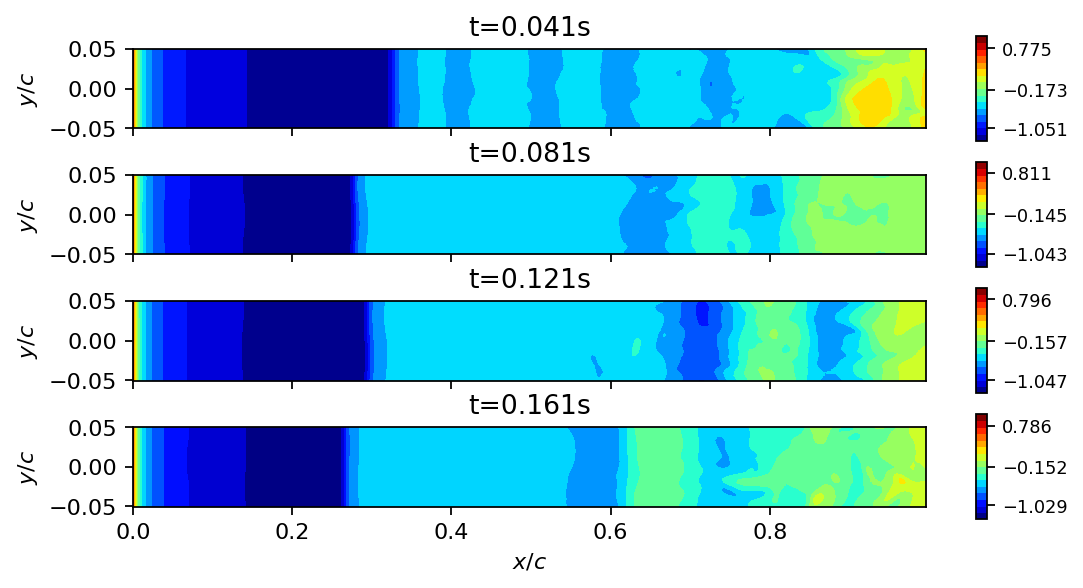

In [6]:
vertices_upper = pt.zeros((points_upper, 2), dtype=pt.float32)
vertices_upper[:, 0] = pt.masked_select(vertices[:, 0], mask)
vertices_upper[:, 1] = pt.masked_select(vertices[:, 2], mask)

fig, axarr = plt.subplots(4, 1, figsize=(8, 4), sharex=True)

for ax, i in zip(axarr, [40, 80, 120, 160]):
    add_surface_plot_to_axis(ax, vertices_upper, data_matrix[:, i])
    ax.set_ylabel(r"$y/c$")
    ax.set_title(f"t={times[i]}s")
    
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

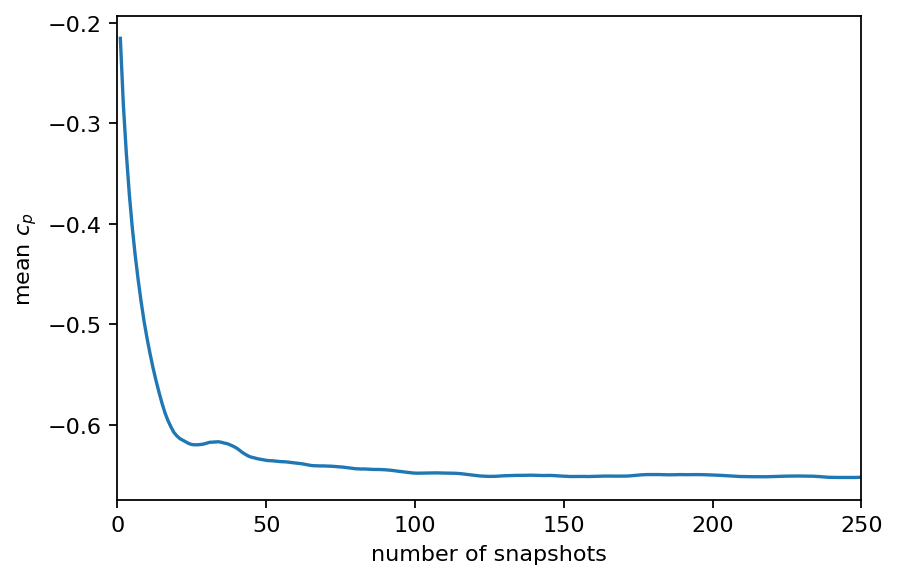

In [7]:
mean_cp = [data_matrix[:, :i].mean() for i in range(1, len(times)+1)]

fig, ax = plt.subplots()
ax.plot(range(1, len(times)+1), mean_cp)
ax.set_xlabel("number of snapshots")
ax.set_ylabel(r"mean $c_p$")
ax.set_xlim(0, len(times))
plt.show()

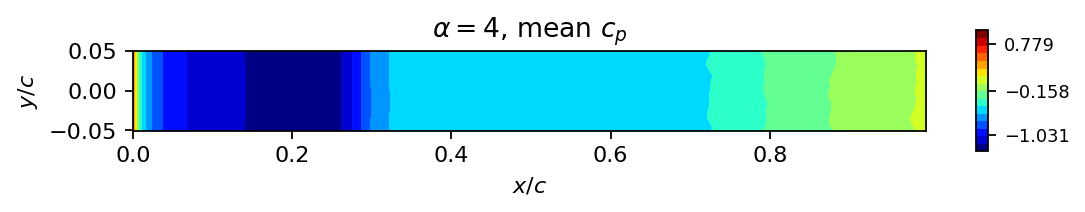

In [8]:
# we compute the mean starting from the 100th snapshot
cp_mean = pt.mean(data_matrix[:, 100:], dim=1)

fig, ax = plt.subplots(1, 1, figsize=(8, 1), sharex=True)
add_surface_plot_to_axis(ax, vertices_upper, cp_mean)
ax.set_xlabel(r"$x/c$")
ax.set_ylabel(r"$y/c$")
ax.set_title(r"$\alpha = 4$, mean $c_p$")
plt.show()

## Singular value decomposition

Examining the singular values of an SVD is an excellent first step to identify coherent structures, to determine the rank of the data matrix and to identify the number of modes required to capture a certain amount of variance in the data. As can be seen in the first plot below, the singular values decay slowly and the first mode captures less than ten percent of variance in the data. This behavior is typical for turbulent flows because turbulence is a phenomenon characterized by a broad range of temporal and spatial scales. We also visualize the POD modes (left singular vectors) and the POD mode coefficients (product of singular values and right singular vectors) to allow a visual comparison to the DMD modes in the following section.

In [9]:
data_matrix = data_matrix[:, 100:] - data_matrix[:, 100:].mean(dim=1).unsqueeze(-1)
svd = SVD(data_matrix, rank=200)
print(svd)

SVD of a 13950x150 data matrix
Selected/optimal rank: 150/51
data type: torch.float32 (4b)
truncated SVD size: 8.0687Mb


In [10]:
s = svd.s
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 99 percent
i_99 = bisect.bisect_right(s_cum, 99)

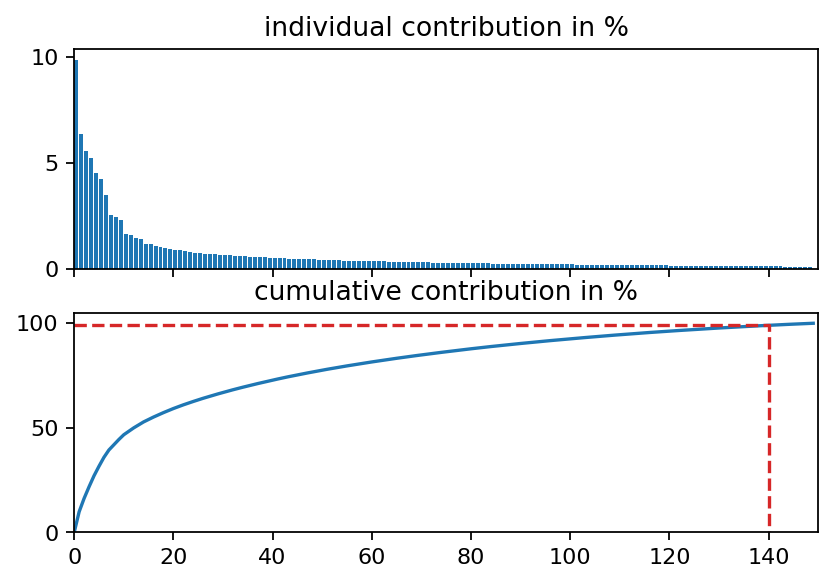

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(s.shape[0]), s_rel, align="edge")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, 150)
ax2.set_ylim(0, 105)
ax1.set_title("individual contribution in %")
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_99, i_99], [s_cum[i_99], s_cum[i_99], 0], ls="--", color="C3")
plt.show()

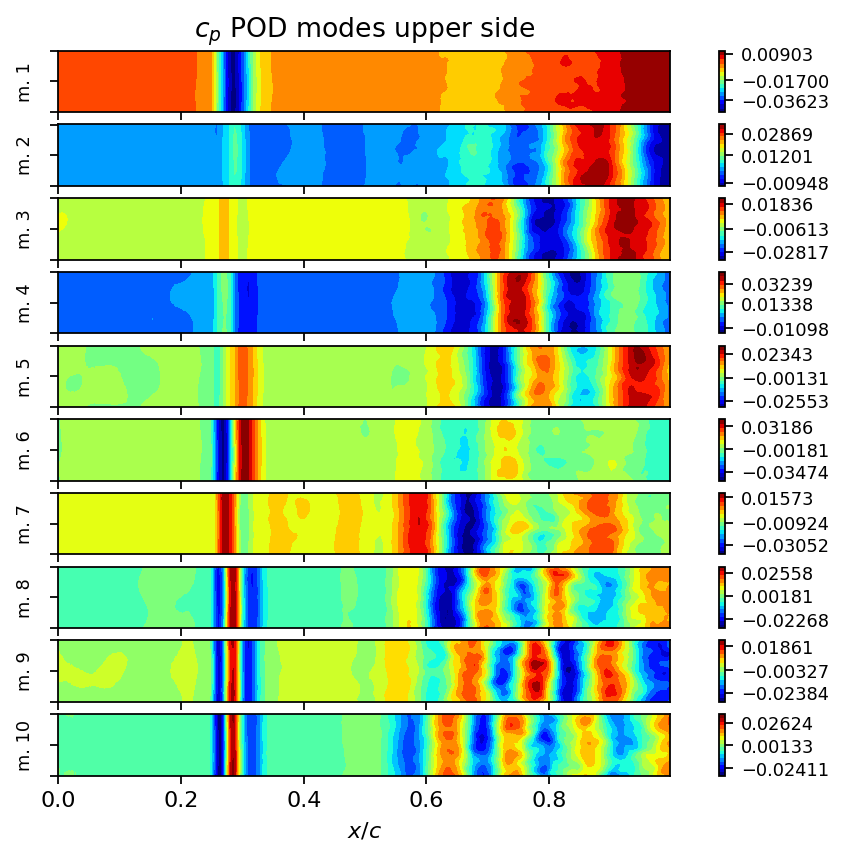

In [12]:
modes = list(range(10))
height = 0.6

fig, axarr = plt.subplots(len(modes), 1, figsize=(8, height*len(modes)), sharex=True, sharey=True)
for row in range(len(modes)):
    add_surface_plot_to_axis(axarr[row], vertices_upper, svd.U[:, row])
    axarr[row].set_ylabel(f"m. {row+1}", fontsize=8)
    axarr[row].set_yticklabels([])
axarr[0].set_title(r"$c_p$ POD modes upper side")
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

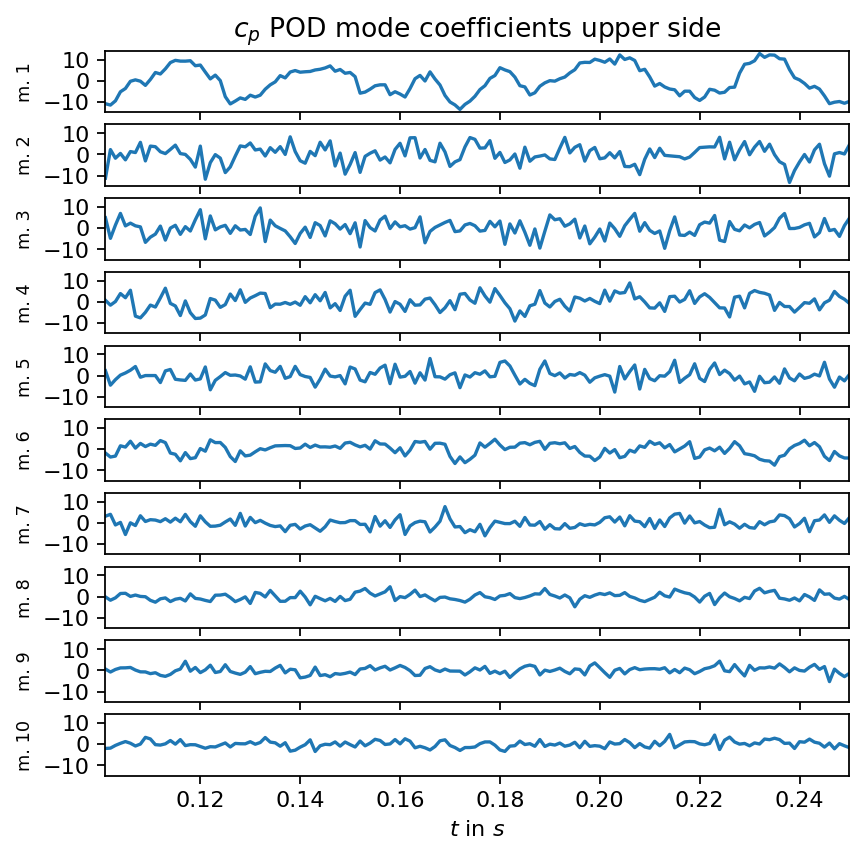

In [13]:
times_num = [float(t) for t in times[100:]]
height = 0.6

fig, axarr = plt.subplots(len(modes), 1, figsize=(6, height*len(modes)), sharex=True, sharey=True)
for row in range(len(modes)):
    axarr[row].plot(times_num, svd.V[:, row]*svd.s[row])
    axarr[row].set_ylabel(f"m. {row+1}", fontsize=8)
axarr[0].set_title(r"$c_p$ POD mode coefficients upper side")
axarr[-1].set_xlim(times_num[0], times_num[-1])
axarr[-1].set_xlabel(r"$t$ in $s$")
plt.show()

## Dynamic mode decomposition

DMD identifies relevant modes associated with specific frequencies that best describe the linear dynamics. As we could see in the singular values, the snapshot data contains a significant amount of resolved turbulence, which is impossible to capture using only a few POD modes. Therefore, we will not truncate the SVD when computing the exact DMD in this example.

In [14]:
dt = times_num[1] - times_num[0]
dmd = DMD(data_matrix, dt, rank=200)
print(dmd)

SVD:
SVD of a 13950x149 data matrix
Selected/optimal rank: 149/51
data type: torch.float32 (4b)
truncated SVD size: 8.0143Mb
LSQ:
Overall DMD size: 24.0429Mb


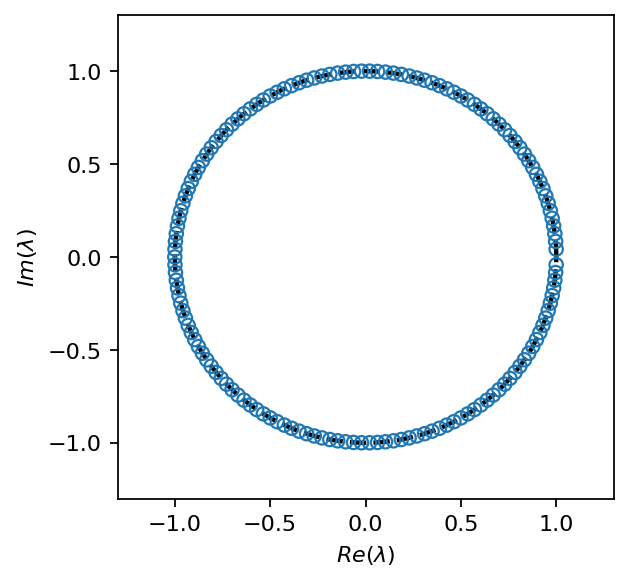

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
t = pt.linspace(0, 2 * np.pi, 100)
ax.plot(pt.cos(t), pt.sin(t), ls="--", color="k", lw=2)
ax.scatter(dmd.eigvals.real, dmd.eigvals.imag, facecolors='none', edgecolors="C0", zorder=7)
ax.set_xlim(-1.3, 1.3)
ax.set_ylim(-1.3, 1.3)
ax.set_xlabel(r"$Re(\lambda)$")
ax.set_ylabel(r"$Im(\lambda)$")
plt.show()

The buffet frequency reported in [Static and Dynamic Pressure Measurements on a NACA 0012 Airfoil in the Ames High Reynolds Number Facility](https://ntrs.nasa.gov/citations/19850019511) by J. B. McDevitt and A. F. Okuno is approximately $31 Hz$ (set 1 flow conditions in the report). This frequency was obtained from pressure measurement at $50\%$ chord on the upper side of the airfoil. The buffet frequency is also identified in the current DMD analysis shown in the spectrum below (up to the spectral resolution accuracy). Two modes with frequencies of $29Hz$ and $33Hz$ are identified as most dominant.

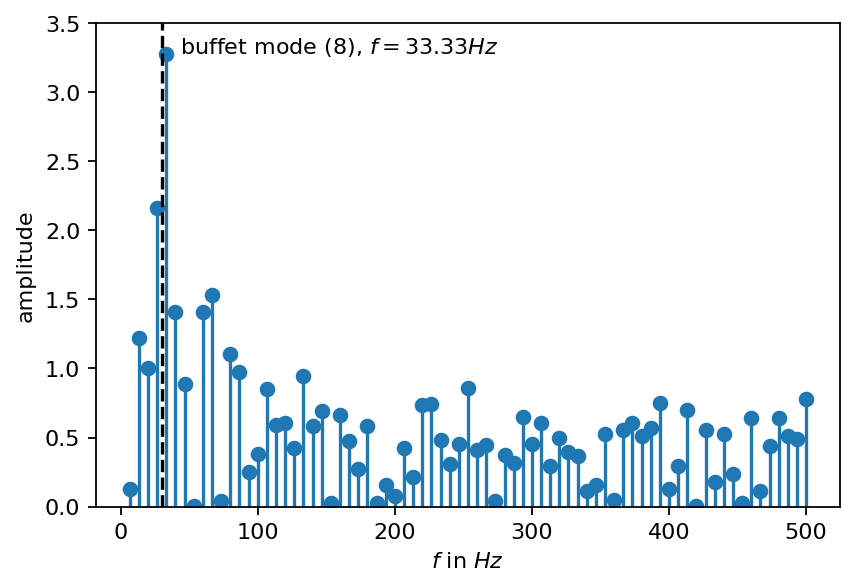

In [16]:
amplitude = dmd.amplitude.real.abs()
freq = dmd.frequency
freq_i_pos = (freq > 0).nonzero().flatten()

fig, ax= plt.subplots()
ax.stem(freq[freq_i_pos].numpy(), amplitude[freq_i_pos].numpy(), basefmt="none")
_, top_pos = amplitude[freq_i_pos].topk(1)
top_i = freq_i_pos[top_pos].item()
ax.text(freq[top_i]+10, amplitude[top_i], r"buffet mode ({:d}), $f={:2.2f}Hz$".format(top_i, freq[top_i]))
ax.set_ylim(0, 3.5)
ax.axvline(30, ls="--", c="k")
ax.set_xlabel(r"$f$ in $Hz$")
ax.set_ylabel("amplitude")
plt.show()

Besides the dominant buffet frequency, analyzing the spectrum reveals various harmonics and triads:

- modes 18 and 59 are harmonics of mode 8
- modes 10, 16, 22 are harmonics of mode 4
- mode 6 is a harmonic of mode 2
- mode 24 is a triad of mode 8 and 4

Harmonic and triads may be used to create very simple models of the buffet phenomenon, which we will demonstrate in another tutorial. Finally, we visualize the first ten modes associated with the highest amplitudes.

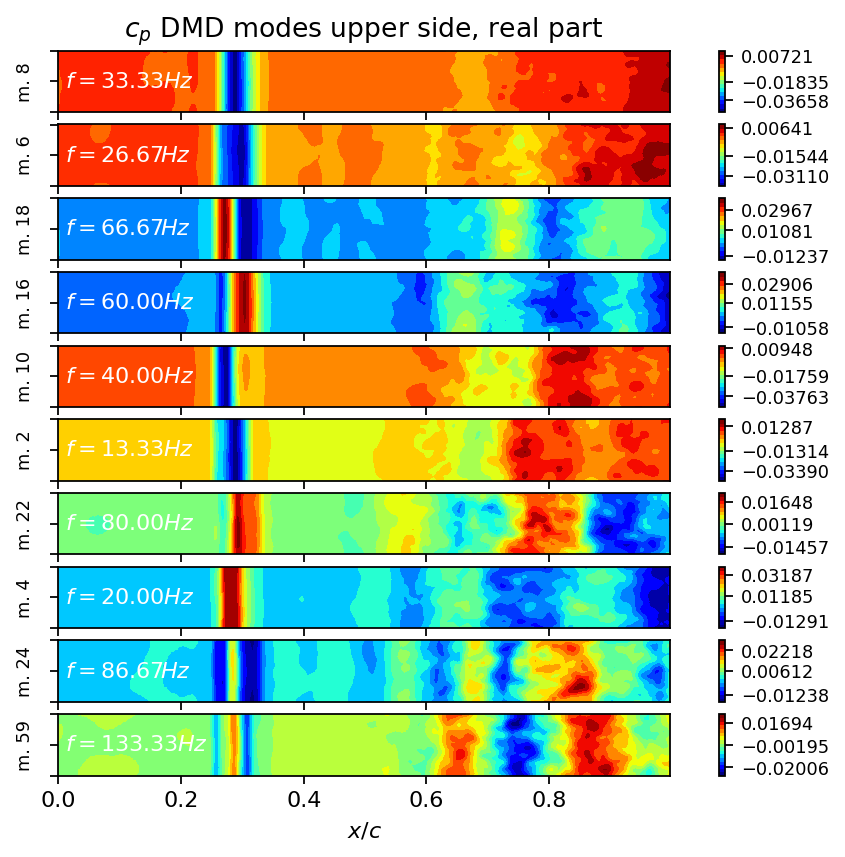

In [17]:
_, top_pos = amplitude[freq_i_pos].topk(10)
top_i = freq_i_pos[top_pos]

fig, axarr = plt.subplots(len(top_i), 1, figsize=(8, height*len(top_i)), sharex=True, sharey=True)
for row, mode_i in enumerate(top_i):
    add_surface_plot_to_axis(axarr[row], vertices_upper, dmd.modes[:, mode_i].real)
    axarr[row].text(0.01, 0, r"$f={:2.2f}Hz$".format(round(freq[mode_i].item(), 2)), color="w", va="center")
    axarr[row].set_ylabel(f"m. {mode_i}", fontsize=8)
    axarr[row].set_yticklabels([])
axarr[0].set_title(r"$c_p$ DMD modes upper side, real part")
axarr[-1].set_xlabel(r"$x/c$")
plt.show()

The modes visualized as images may be difficult to interprete since there are real and imaginary parts which contribute to the reconstruction. Animating modes in isolation or combinations of modes is an excellent alternative to create interpretable visualizations. Since we subtracted the temporal mean from each column of the data matrix, we now add it to the reconstruction to obtain more interpretable animations.

In [18]:
def animate_reconstruction(reconstruction):
    min_val, max_val = reconstruction.min(), reconstruction.max()
    fig, ax = plt.subplots(figsize=(8, height))
    def init():
        tri = ax.tricontourf(vertices_upper[:, 0], vertices_upper[:, 1], reconstruction[:, 0], levels=15, cmap="jet", vmin=min_val, vmax=max_val)
        ax.set_aspect("equal", 'box')
        ax.set_xlabel(r"$x/c$")
        ax.set_ylabel(r"$y/c$")
        return tri
    def animate(i):
        tri = ax.tricontourf(vertices_upper[:, 0], vertices_upper[:, 1], reconstruction[:, i], levels=15, cmap="jet", vmin=min_val, vmax=max_val)
        ax.set_aspect("equal", 'box')
        return tri
    return FuncAnimation(fig, animate,  frames=reconstruction.shape[1], repeat=True, interval=30)

In [19]:
anim_mode_8 = animate_reconstruction(dmd.partial_reconstruction({8})[:, :100] + cp_mean.unsqueeze(-1))
plt.close()

In [20]:
HTML(anim_mode_8.to_jshtml())

In [21]:
anim_mode_18 = animate_reconstruction(dmd.partial_reconstruction({18})[:, :100] + cp_mean.unsqueeze(-1))
plt.close()

In [22]:
HTML(anim_mode_18.to_jshtml())

In [23]:
anim_mode_8_18 = animate_reconstruction(dmd.partial_reconstruction({8, 18})[:, :100] + cp_mean.unsqueeze(-1))
plt.close()

In [24]:
HTML(anim_mode_8_18.to_jshtml())